In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [92]:
import copy
from hexalattice.hexalattice import *

# Visualize data
def visualize_data(N, nu, threshold, shape_name):
    shape_name_str = shape_name
    N_str = str(N)
    if shape_name == "Cube":
        shape_name_str = "Cube\\x2_widths"
        N_str = str(N)
        width = 2*N
    elif shape_name == "RDG4":
        shape_name_str = "RDG_square_int"
        N_str = f"{int(1.5*N)}x{int(1.5*N)}x{N}"
        width = int(1.5*N)
    elif shape_name == "RDG6":
        visualize_hexagon_data(N, nu, threshold)
        return
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG4, RDG6)")
        return

    filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((width, width))
    print("Datapoints:",len(strike_data_str))

    for point in strike_data_str:
        point = point.split(',')
        x_coord = ...
        y_coord = ...
        if shape_name == "Cube":
            x_coord = point[1]
            y_coord = point[2]
        elif shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = point[0]
            y_coord = point[1]
        x_coord = x_coord.strip()
        if shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = x_coord.strip('(')
            x_coord = x_coord.strip()
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1

    cmap = matplotlib.cm.viridis
    plt.imshow(strike_data, cmap=cmap)
    plt.colorbar()
    plt.show()


base_dim_to_height = {30:11, 40:14, 50:18, 60:21, 70:25, 80:28, 90:32}

def visualize_hexagon_data(N, nu, threshold):
    def float_to_rgb_color(value, cmap_name='viridis'):
        value = min(0.9999999999, max(0, value))
        
        cmap = plt.get_cmap(cmap_name)
        
        rgba = cmap(value)
        
        return [rgba[0], rgba[1], rgba[2]]

    width=N
    height=base_dim_to_height[width] # fix this

    filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\RDG_hex_int\\{width}x{width}x{height}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((N, N))
    print("Datapoints:", len(strike_data_str))

    for point in strike_data_str:
        point = point.split(',')
        x_coord = point[0]
        y_coord = point[1]
        x_coord = x_coord.strip()
        x_coord = x_coord.strip('(')
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1
    strike_data /= np.max(strike_data)


    hex_centers, _ = create_hex_grid(nx=N,
                                        ny=N,
                                        do_plot=False)
    x_hex_coords = hex_centers[:, 0]
    x_hex_coords = np.array([val - (i*1)//(N) + (i*1)//(2*N) for i, val in enumerate(x_hex_coords)])
    #x_hex_coords = np.array([val + (i)//(N) for i, val in enumerate(x_hex_coords)])
    y_hex_coords = hex_centers[:, 1]

    colors = np.array([float_to_rgb_color(strike_data[x_pos, y_pos], cmap_name='plasma') for y_pos in range(N) for x_pos in range(N)])
    edge_colors = copy.deepcopy(colors)

        
    effective_width = width//2+1
    y_pos_cells = width*2//3
    effective_depth = y_pos_cells * np.sqrt(3)/2
    diff = int(effective_depth - effective_width)
    effective_width += diff

    new_edge_colors = []
    new_colors = []
    new_x_hex_coords = []
    new_y_hex_coords = []

    for x_pos in range(effective_width):
        for y_pos in range(y_pos_cells):
            y_pos += y_pos_cells//6
            x_pos_a = x_pos + y_pos//2 + effective_width//6 - effective_width//12
            y_pos_a = y_pos*2 + y_pos_cells//3+1
            #if x_pos == 0 or x_pos == (effective_width-1) or y_pos == y_pos_cells//6 or y_pos == (y_pos_cells-1+y_pos_cells//6):
                #edge_colors[x_pos_a + y_pos_a//2 * width] = [1,1,1]
                #self.fixed_grid[x_pos+y_pos//2 + effective_width//6, y_pos + effective_width//3+1, self.dim['depth']-1] = -1
            new_edge_colors.append(edge_colors[x_pos_a + y_pos_a//2 * width])
            new_colors.append(colors[x_pos_a + y_pos_a//2 * width])
            new_x_hex_coords.append(x_hex_coords[x_pos_a + y_pos_a//2 * width])
            new_y_hex_coords.append(y_hex_coords[x_pos_a + y_pos_a//2 * width])
            
    new_edge_colors = np.array(new_edge_colors)
    new_colors = np.array(new_colors)
    new_x_hex_coords = np.array(new_x_hex_coords)
    new_y_hex_coords = np.array(new_y_hex_coords)
            


    print()
    print("Effective depth (y-pos):", effective_depth)
    print("Effective width (x-pos):", effective_width)
    print("y_pos_cells", y_pos_cells)
    print("diff", diff)
            

    plot_single_lattice_custom_colors(new_y_hex_coords, new_x_hex_coords,
                                        face_color=new_colors,
                                        edge_color=new_colors,
                                        min_diam=0.99,
                                        plotting_gap=0.08,
                                        rotate_deg=30)
    plt.show()


In [78]:
# Variance of 2D data
def calc_variance(N, nu, threshold, shape_name, print_output=False):
    if shape_name == "Cube":
        shape_name_str = "Cube\\x2_widths"
        N_str = str(N)
        width = int(2*N)
    elif shape_name == "RDG4":
        shape_name_str = "RDG_square_int"
        N_str = f"{int(1.5*N)}x{int(1.5*N)}x{N}"
        width = int(1.5*N)
    elif shape_name == "RDG6":
        shape_name_str = "RDG_hex_int"
        N_str = f"{N}x{N}x{base_dim_to_height[N]}"
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG4, RDG6)")
        return

    filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((width, width), dtype=int)

    for point in strike_data_str:
        point = point.split(',')
        if shape_name == "Cube":
            x_coord = point[1]
            y_coord = point[2]
        elif shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = point[0]
            y_coord = point[1]
        x_coord = x_coord.strip()
        if shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = x_coord.strip('(')
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1
    
    x_indices, y_indices = np.nonzero(strike_data)

    if shape_name == "RDG6":
        # Convert data to a list of x-positions and one of y-positions
        ...
    else:
        # sum all rows
        x_data_flat = np.sum(strike_data, axis=1)
        # sum all columns
        y_data_flat = np.sum(strike_data, axis=0)

        # Produce a list where number of elements with index value is proportional to strike_data value
        multiple_x_indices = []
        for x in x_indices:
            multiple_x_indices.extend([x]*x_data_flat[x])

        multiple_y_indices = []
        for y in y_indices:
            multiple_y_indices.extend([y]*y_data_flat[y])

        # Average x and y pos, variance of center
        mean_x_pos = np.mean(multiple_x_indices)
        mean_y_pos = np.mean(multiple_y_indices)
        var_x_pos = np.var(multiple_x_indices)
        var_y_pos = np.var(multiple_y_indices)

        # Overall variance (average error)
        x_distances = []
        y_distances = []
        euclidian_distances = []
        for x in range(width):
            for y in range(width):
                if strike_data[x,y] > 0:
                    # Error in x, y, and overall 
                    x_distances.extend([(x - mean_x_pos)**2] * strike_data[x,y])
                    y_distances.extend([(y - mean_y_pos)**2] * strike_data[x,y])
                    euclidian_distances.extend([((x - mean_x_pos)**2 + (y - mean_y_pos)**2)] * strike_data[x,y])
        
        # Average error
        var_x_pos = np.mean(x_distances)
        var_y_pos = np.mean(y_distances)
        overall_var = np.mean(np.array(euclidian_distances)/2)

    if print_output:
        print("Datapoints:", len(strike_data_str))
        print(f"Mean x-pos: {mean_x_pos}")
        print(f"Mean y-pos: {mean_y_pos}")
        print(f"Var x-pos: {var_x_pos}")
        print(f"Var y-pos: {var_y_pos}")
        print(f"Overall variance: {overall_var}")
        print("Variance of variances:")
        print(np.var(x_distances))
        print(np.var(y_distances))
        print(np.var(np.array(euclidian_distances)/np.sqrt(2)))
    
    return overall_var, var_x_pos, var_y_pos, mean_x_pos, mean_y_pos

Datapoints: 2874

Effective depth (y-pos): 22.516660498395403
Effective width (x-pos): 22
y_pos_cells 26
diff 1


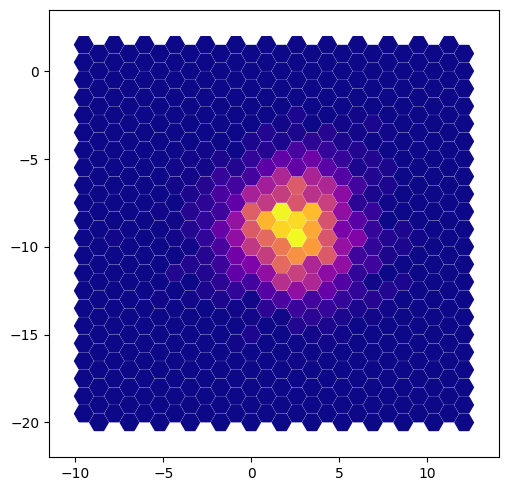

In [99]:
visualize_data(40, 6, 0.001, "RDG6")

In [72]:
calc_variance(30, 6, 0.001, "RDG4", True);

Datapoints: 10467
Mean x-pos: 21.50825827447423
Mean y-pos: 21.35200591808697
Var x-pos: 19.132487235511086
Var y-pos: 19.579128820170393
Overall variance: 19.355808027840737
Variance of variances:
757.8216169670394
781.3619998018601
758.0718571337289


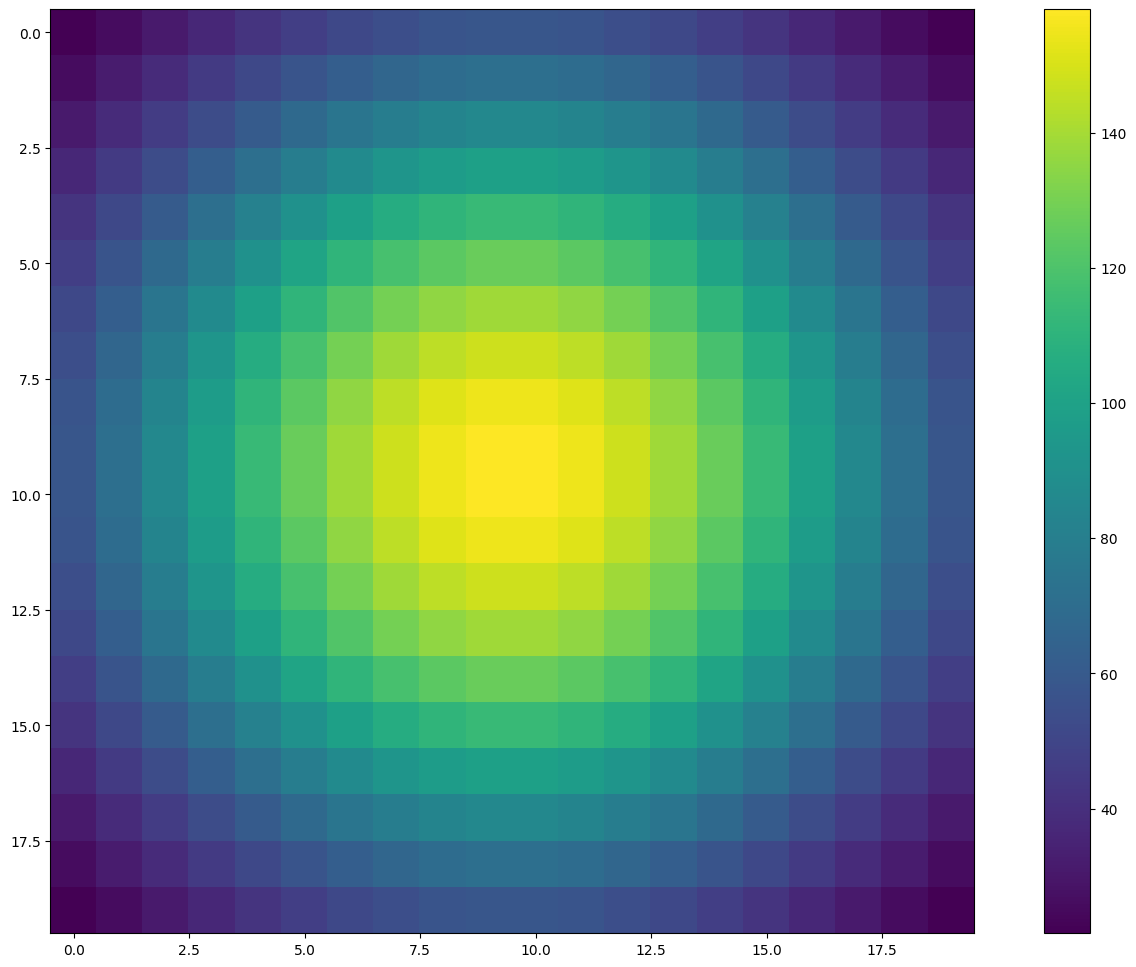

158
Average distances
24.579113924050635
24.579113924050635
24.579113924050635
Variances:
672.461065443673
672.4610654436729
671.9032629628172


In [46]:

from scipy.stats import multivariate_normal

multivariate_normal_obj = multivariate_normal([0, 0], [[2.0, 0], [0, 2]])

grid = np.array((20,20))
mg = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
grid = multivariate_normal_obj.pdf(np.dstack(mg)) * 2000
cmap = matplotlib.cm.viridis
fig = plt.figure(figsize=(18,12))
plt.imshow(grid, cmap=cmap)
plt.colorbar()
plt.show()

grid = np.array(grid, dtype=int)

print(np.max(grid))

x_indices, y_indices = np.nonzero(grid)

#print("x_indices", x_indices)

x_data_flat = np.sum(grid, axis=1, dtype=int)
y_data_flat = np.sum(grid, axis=0, dtype=int)
#print(x_data_flat)
multiple_x_indices = []
for x in x_indices:
    multiple_x_indices.extend([x]*x_data_flat[x])

multiple_y_indices = []
for y in y_indices:
    multiple_y_indices.extend([y]*y_data_flat[y])

#print("multiple_x_indices", multiple_x_indices)
mean_x_pos = np.mean(multiple_x_indices)
mean_y_pos = np.mean(multiple_y_indices)
var_x_pos = np.var(multiple_x_indices)
var_y_pos = np.var(multiple_y_indices)

x_distances = []
y_distances = []
euclidian_distances = []
for x in range(20):
    for y in range(20):
        x_distances.extend([(x - mean_x_pos)**2] * grid[x,y])
        y_distances.extend([(y - mean_y_pos)**2] * grid[x,y])
        euclidian_distances.extend([((x - mean_x_pos)**2 + (y - mean_y_pos)**2)] * grid[x,y])


print("Average distances")
print(np.mean(x_distances))
print(np.mean(y_distances))
print(np.mean(euclidian_distances)/2)
print("Variances:")
print(np.var(x_distances))
print(np.var(y_distances))
print(np.var(np.array(euclidian_distances)/np.sqrt(2)))

Datapoints: 2671


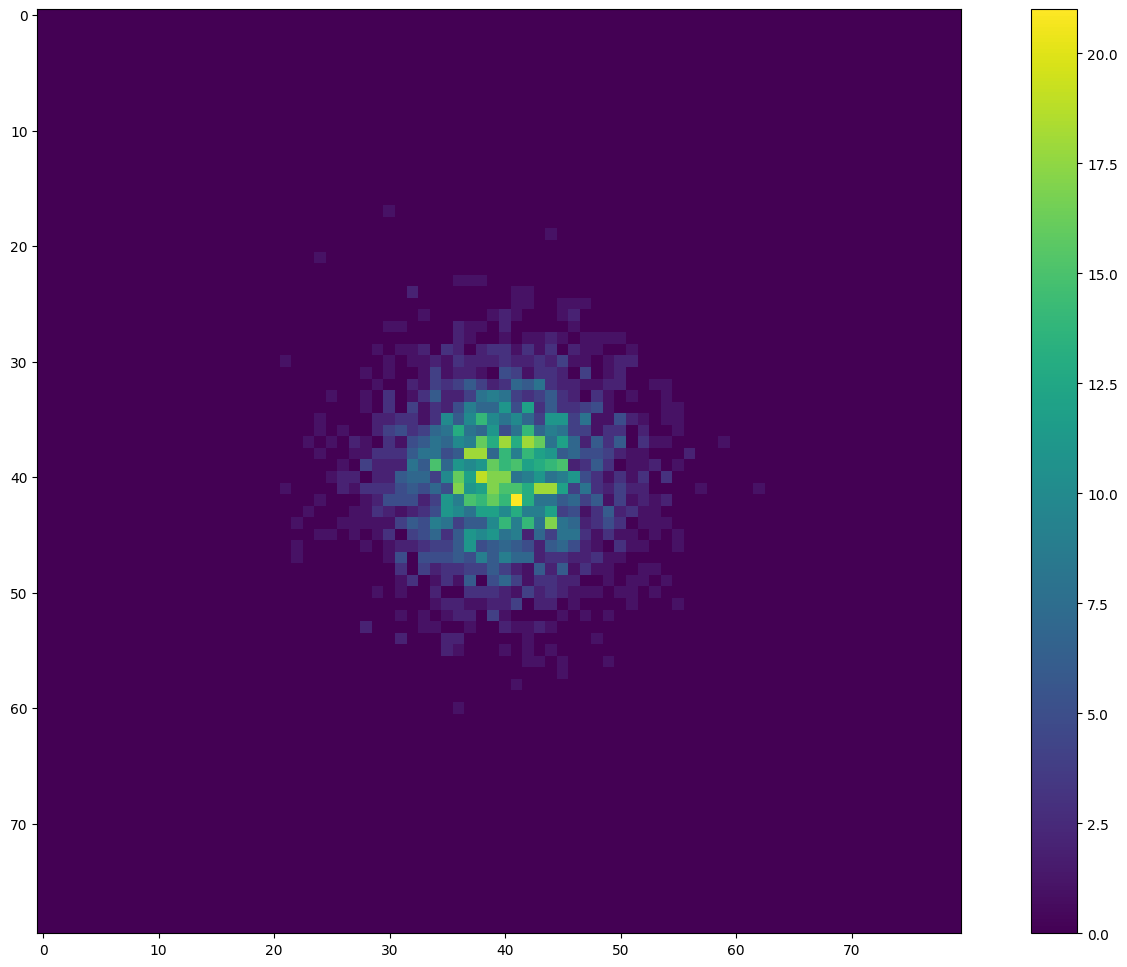

Datapoints: 1295


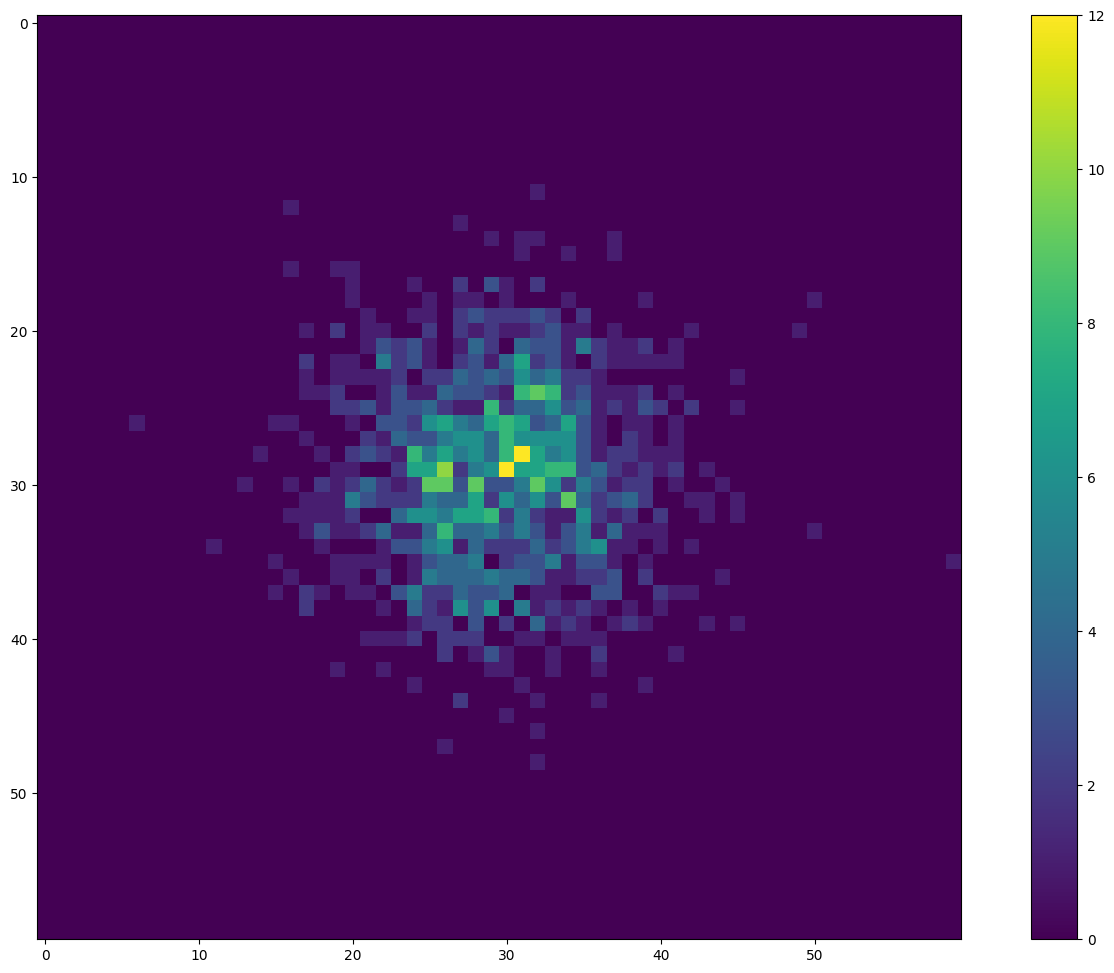

Datapoints: 1156


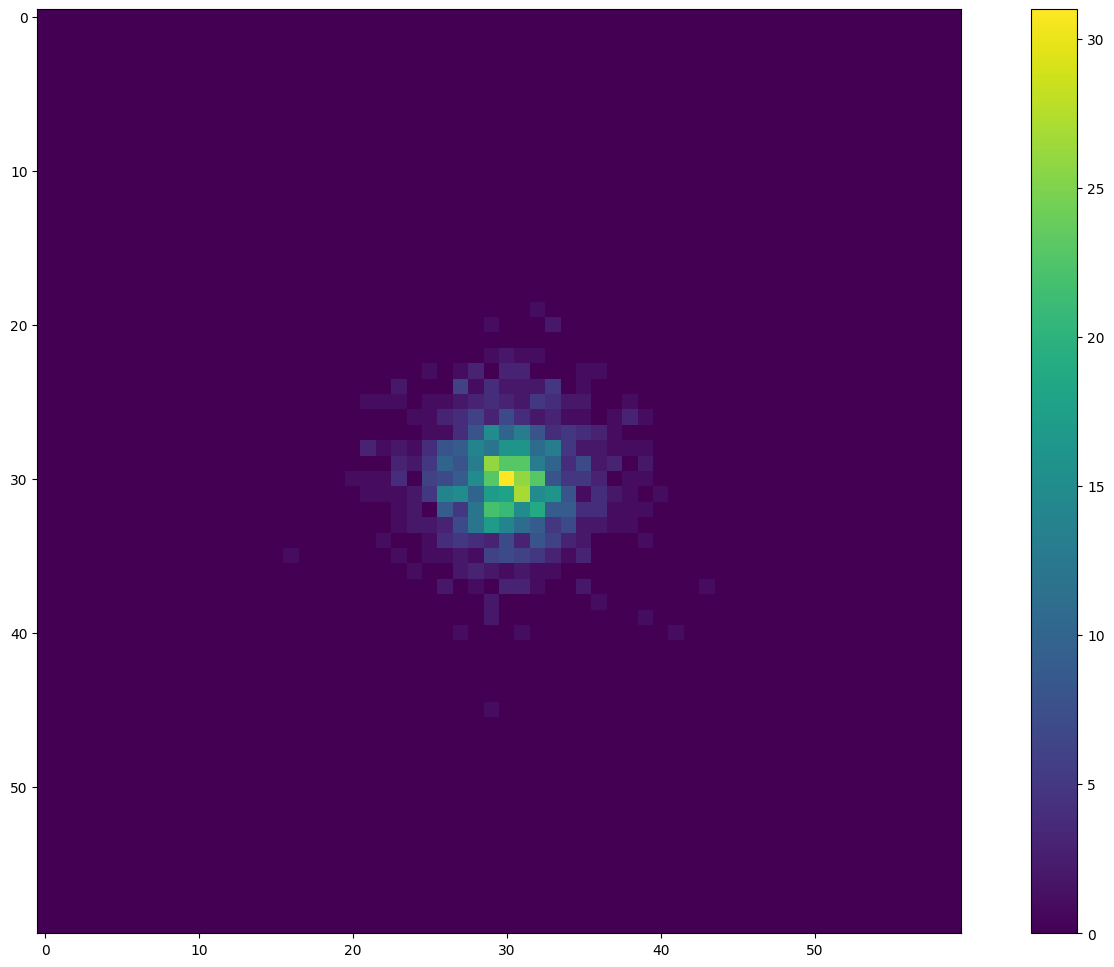

In [26]:
visualize_data(40, 2.5, 0.001, "Cube")
visualize_data(40, 6, 0.001, "RDG4")
visualize_data(30, 6, 0.001, "Cube")